Dataset loaded

Top Spam Words:
- your
- com
- http
- escapelong
- you
- of
- and
- to
- the
- escapenumber

Accuracy: 0.9675272755409972
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     20467
           1       0.95      0.98      0.97     18304

    accuracy                           0.97     38771
   macro avg       0.97      0.97      0.97     38771
weighted avg       0.97      0.97      0.97     38771



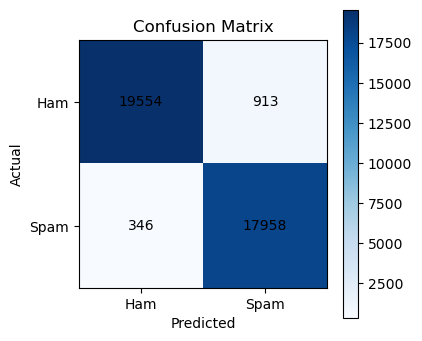

Model saved

Test Example:
SPAM


In [7]:
#Spam Email Classifier


import pandas as pd
import re
import joblib
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier


# 1. Load dataset (fix Unicode error)
df = pd.read_csv("spam_Emails_data.csv", encoding="latin1")
print("Dataset loaded")

# Normalize column names
df.columns = [c.lower() for c in df.columns]

# Auto-fix column names
if "text" not in df.columns:
    df.rename(columns={df.columns[0]: "text"}, inplace=True)
if "label" not in df.columns:
    df.rename(columns={df.columns[1]: "label"}, inplace=True)


# 2. Clean text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["text"] = df["text"].apply(clean_text)


# 3. Convert labels (spam=1, ham=0)
df["label"] = df["label"].astype(str).str.lower().map(
    lambda x: 1 if "spam" in x or x == "1" else 0
)
df = df.dropna()


# 4. Split data
X = df["text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# 5. TF-IDF
vectorizer = TfidfVectorizer(max_features=3000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


# 6. Show TOP spam words
feature_names = np.array(vectorizer.get_feature_names_out())
spam_scores = X_train_vec[y_train == 1].sum(axis=0)

if spam_scores.shape[1] > 0:
    top_idx = np.asarray(spam_scores).ravel().argsort()[-10:]
    print("\nTop Spam Words:")
    for w in feature_names[top_idx]:
        print("-", w)


# 7. Train model
model = XGBClassifier(eval_metric="logloss")
model.fit(X_train_vec, y_train)


# 8. Evaluate
y_pred = model.predict(X_test_vec)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


# 9. Confusion Matrix (BEGINNER-SAFE VERSION)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

labels = ["Ham", "Spam"][:cm.shape[0]]
plt.xticks(range(cm.shape[0]), labels)
plt.yticks(range(cm.shape[0]), labels)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# 10. Save model
joblib.dump(model, "spam_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
print("Model saved")


# 11. Test custom email
def predict_email(email):
    email = clean_text(email)
    vec = vectorizer.transform([email])
    return "SPAM" if model.predict(vec)[0] == 1 else "NOT SPAM"

print("\nTest Example:")
print(predict_email("Congratulations! You won a free prize"))
